In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from PIL import Image
import os
from torchvision import transforms
import cv2 as cv

In [2]:
# prompt: count the number of file in one directory

import os

# Get the directory path
directory_path = "/kaggle/input/hc-dataset/training_set/training_set"

# Count the number of files in the directory
num_files = len(os.listdir(directory_path))

# Print the number of files
print(f"Number of files in the directory: {num_files}")


Number of files in the directory: 1998


In [3]:
def masking(img_):
    im_gr = cv.cvtColor(img_, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(im_gr, 127, 255, 0)
    contours, hierarchy_ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    ellipse = cv.fitEllipse(contours[0])
    return cv.ellipse(img_, ellipse, (255,255,255), -1)

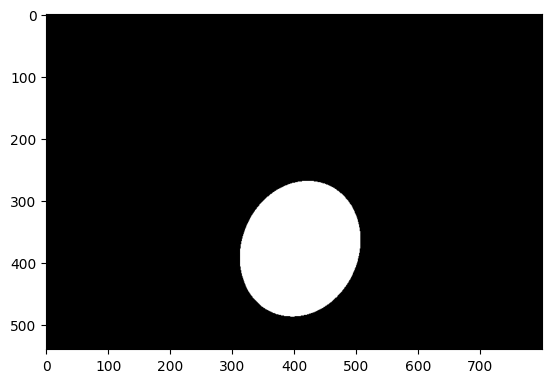

In [4]:
test = cv.imread("/kaggle/input/hc-dataset/training_set/training_set/000_HC_Annotation.png")
plt.imshow(masking(test))

In [34]:
X = []
y = []
y_original = []
directory_path = "/kaggle/input/hc-dataset/training_set/training_set"

sorted_list = os.listdir(directory_path)
sorted_list.sort()
for filename in sorted_list:
    filepath = os.path.join(directory_path, filename)
    file_content = np.array(Image.open(filepath, 'r'))
    if file_content.shape != (540,800):
        continue
    if "Annotation" in filename:
        y.append(masking(cv.imread(filepath)))
        y_original.append(cv.imread(filepath))
    else:
        X.append(file_content)


In [35]:
X_np = np.array(X)
print(X_np.shape)
y_np = np.array(y)[:,:,:,1]
print(y_np.shape)
y_np_original = np.array(y_original)[:,:,:,1]
print(y_np_original.shape)

(975, 540, 800)
(975, 540, 800)
(975, 540, 800)


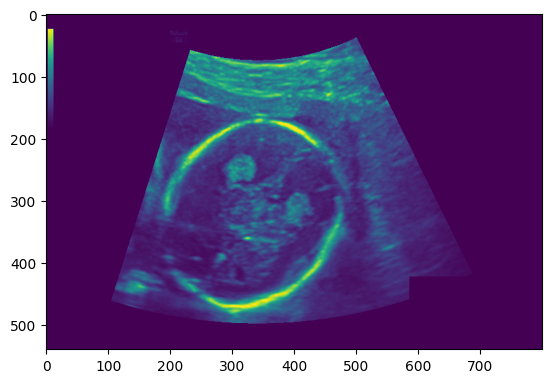

In [8]:
plt.imshow(X_np[302,:,:])

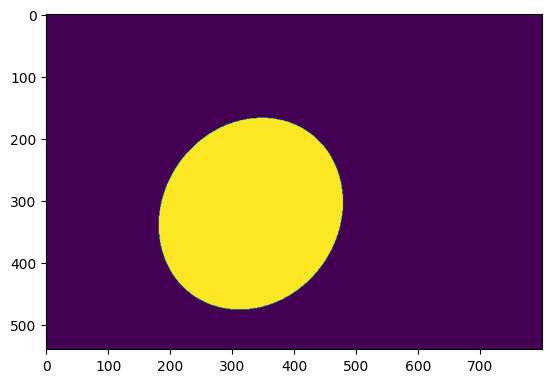

In [9]:
plt.imshow(y_np[302,:,:])

In [36]:
X_train = X_np[:750, :, :]
print(X_train.shape)
X_valid = X_np[750:, :, :]
print(X_valid.shape)
y_train = y_np[:750, :, :]
print(y_train.shape)
y_valid = y_np[750:, :, :]
print(y_valid.shape)
y_train_original = y_np_original[:750, :, :]
print(y_train_original.shape)
y_valid_original = y_np_original[750:, :, :]
print(y_valid_original.shape)

(750, 540, 800)
(225, 540, 800)
(750, 540, 800)
(225, 540, 800)
(750, 540, 800)
(225, 540, 800)


In [8]:
train_set = []
valid_set = []
for i in range(X_train.shape[0]):
    train_dict = {
        'X': X_train[i,:,:],
        'y': y_train[i,:,:]
    }
    train_set.append(train_dict)

for i in range(X_valid.shape[0]):
    valid_dict = {
        'X': X_valid[i,:,:],
        'y': y_valid[i,:,:]
    }
    valid_set.append(valid_dict)



In [9]:
print(f"Number of training sample: {len(train_set)}")
print(f"Number of validating sample: {len(valid_set)}")

Number of training sample: 750
Number of validating sample: 225


In [10]:
transform_X = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_y = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, transform_X, transform_y):
        self.data = data
        self.transform_X = transform_X
        self.transform_y = transform_y
    def __getitem__(self, index):
        X = self.data[index]['X']
        X = self.transform_X(X)
        y = self.data[index]['y']
        y = self.transform_y(y)
        return X, y
    def __len__(self):
        return len(self.data)


In [12]:
train_cd = CustomDataset(train_set, transform_X, transform_y)
train_loader = DataLoader(train_cd, batch_size = 16, shuffle = True)
valid_cd = CustomDataset(valid_set, transform_X, transform_y)
valid_loader = DataLoader(valid_cd, batch_size = 4, shuffle = False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv3x3_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_5 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2,stride=2)
        self.conv3x3_6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2,stride=2)
        self.conv3x3_7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2,stride=2)
        self.conv3x3_8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2,stride=2)
        self.conv3x3_9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.output = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

#     def crop(self, x, out_shape):
#         in_shape = x.shape[-1]
#         out = x[:,:,(in_shape-out_shape)//2:(in_shape-out_shape)//2+out_shape,(in_shape-out_shape)//2:(in_shape-out_shape)//2+out_shape]
#         return(out)
    def forward(self, x):
        cv1 = self.conv3x3_1(x)
#         print(f"Cv1: {cv1.size()}")
#         crop_cv1 = self.crop(cv1, 392)

        cv2 = self.conv3x3_2(cv1)
#         print(f"Cv2: {cv2.size()}")
#         crop_cv2 = self.crop(cv2, 200)

        cv3 = self.conv3x3_3(cv2)
#         print(f"Cv3: {cv3.size()}")
#         crop_cv3 = self.crop(cv3, 104)

        cv4 = self.conv3x3_4(cv3)
#         print(f"Cv4: {cv4.size()}")
#         crop_cv4 = self.crop(cv4, 56)

        cv5 = self.conv3x3_5(cv4)
#         print(f"Cv5: {cv5.size()}")

        upcv1 = self.upconv2x2_1(cv5)
#         print(f"UpCv1: {upcv1.size()}         CropCv4: {cv4.size()}")
        
        cv6 = self.conv3x3_6(torch.cat([cv4, upcv1], dim = 1))
#         print(f"Cv6: {cv6.size()}")

        upcv2 = self.upconv2x2_2(cv6)
#         print(f"UpCv2: {upcv2.size()}         CropCv3: {cv3.size()}")
        cv7 = self.conv3x3_7(torch.cat([cv3, upcv2], dim = 1))

        upcv3 = self.upconv2x2_3(cv7)
#         print(f"UpCv3: {upcv3.size()}         CropCv2: {cv2.size()}")
        cv8 = self.conv3x3_8(torch.cat([cv2, upcv3], dim = 1))

        upcv4 = self.upconv2x2_4(cv8)
#         print(f"UpCv4: {upcv4.size()}         CropCv1: {cv1.size()}")
        cv9 = self.conv3x3_9(torch.cat([cv1, upcv4], dim = 1))

        out = self.output(cv9)

        return out


In [72]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    losses = np.array([])
    for X, y in tqdm(dataloader):
        # Compute prediction error
        pred = model(X.cuda())
        # class_pred = torch.argmax(pred, dim = -1)
        loss = loss_fn(pred, y.cuda())
#         print(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = np.append(losses, loss.item())

    loss_mean = losses.mean()
    print(f"loss mean per batch: {loss_mean:.20f}")
    return loss_mean

In [73]:
def validating(dataloader, model, loss_fn):

    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.cuda(), y.cuda()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss per batch: {test_loss:.20f} \n")
    return test_loss

In [ ]:
model = Model().cuda()
criterion = nn.BCELoss()
optimizer =  torch.optim.Adam(model.parameters(),
                          lr=0.001, weight_decay = 0.00000001, foreach=True)

In [77]:
train_losses = []
val_losses = []
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(train_loader, model, criterion, optimizer))
    val_losses.append(validating(valid_loader, model, criterion))
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.46251323121659299042
Test Error: 
 Avg loss per batch: 0.44091790653111639919 

Epoch 2
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.37215918492763599978
Test Error: 
 Avg loss per batch: 0.38050548967562225489 

Epoch 3
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.34101079182421906166
Test Error: 
 Avg loss per batch: 0.40848474073828311415 

Epoch 4
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.32013608293330414467
Test Error: 
 Avg loss per batch: 0.32367698403826933307 

Epoch 5
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.29760918021202087402
Test Error: 
 Avg loss per batch: 0.34480729646850050152 

Epoch 6
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.28171754200407800317
Test Error: 
 Avg loss per batch: 0.29719721486693934098 

Epoch 7
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.26916728818670232481
Test Error: 
 Avg loss per batch: 0.29015260045988516824 

Epoch 8
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.25535993626777159227
Test Error: 
 Avg loss per batch: 0.25413187083445099024 

Epoch 9
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.24270354496671797673
Test Error: 
 Avg loss per batch: 0.27411129992259175570 

Epoch 10
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.23350265844071166343
Test Error: 
 Avg loss per batch: 0.23597773073012368039 

Epoch 11
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.22028855852624204537
Test Error: 
 Avg loss per batch: 0.22606643746819413132 

Epoch 12
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.21283748016712514262
Test Error: 
 Avg loss per batch: 0.23704911428585387356 

Epoch 13
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.20476575195789337158
Test Error: 
 Avg loss per batch: 0.23250313887470647201 

Epoch 14
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.19685466682657282167
Test Error: 
 Avg loss per batch: 0.23153831221555409847 

Epoch 15
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.18610182753268708633
Test Error: 
 Avg loss per batch: 0.20597823304042481296 

Epoch 16
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.17904933811502254937
Test Error: 
 Avg loss per batch: 0.20671943274506351940 

Epoch 17
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.17475402608830878370
Test Error: 
 Avg loss per batch: 0.18012114026044545589 

Epoch 18
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.16815068842248714898
Test Error: 
 Avg loss per batch: 0.17769925714584819398 

Epoch 19
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.16111057806522288693
Test Error: 
 Avg loss per batch: 0.17922295525408626915 

Epoch 20
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.15464938321012131062
Test Error: 
 Avg loss per batch: 0.17648847505711673378 

Epoch 21
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.09it/s]


loss mean per batch: 0.14986442124589960390
Test Error: 
 Avg loss per batch: 0.16911820230776802854 

Epoch 22
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.14446166474768457055
Test Error: 
 Avg loss per batch: 0.15098272656139574699 

Epoch 23
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.13948717998697401921
Test Error: 
 Avg loss per batch: 0.17078454949353871761 

Epoch 24
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.13436402760921639654
Test Error: 
 Avg loss per batch: 0.15612862821210893305 

Epoch 25
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.12943041800184451606
Test Error: 
 Avg loss per batch: 0.14807289146017610371 

Epoch 26
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.12553817715416562550
Test Error: 
 Avg loss per batch: 0.14507187314723668514 

Epoch 27
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.12220420529867739856
Test Error: 
 Avg loss per batch: 0.13902536844998075738 

Epoch 28
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.11928936268420929634
Test Error: 
 Avg loss per batch: 0.19792192507731287687 

Epoch 29
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.12551162661390102837
Test Error: 
 Avg loss per batch: 0.17307812184618229234 

Epoch 30
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.11821623606250640515
Test Error: 
 Avg loss per batch: 0.12617434652750952884 

Epoch 31
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.11082063456799121082
Test Error: 
 Avg loss per batch: 0.11854553810859981555 

Epoch 32
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.10684522225501690007
Test Error: 
 Avg loss per batch: 0.11599693551921007317 

Epoch 33
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.10382728611535214924
Test Error: 
 Avg loss per batch: 0.12593192750947518332 

Epoch 34
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.10031397815080399238
Test Error: 
 Avg loss per batch: 0.12016086607125767149 

Epoch 35
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.09767506826431193723
Test Error: 
 Avg loss per batch: 0.12409011078508276615 

Epoch 36
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.09360650784157692472
Test Error: 
 Avg loss per batch: 0.12400534265396888356 

Epoch 37
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.09075241551754321956
Test Error: 
 Avg loss per batch: 0.11134744121840126074 

Epoch 38
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.08846524880921587120
Test Error: 
 Avg loss per batch: 0.12022242106889423352 

Epoch 39
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.08617387046205236822
Test Error: 
 Avg loss per batch: 0.11862330661531080012 

Epoch 40
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.08580386004549392376
Test Error: 
 Avg loss per batch: 0.10655086448318079606 

Epoch 41
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.08356055760003150423
Test Error: 
 Avg loss per batch: 0.12387224195296303586 

Epoch 42
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.07987388207557354070
Test Error: 
 Avg loss per batch: 0.11903737746832664113 

Epoch 43
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.07700864098807598535
Test Error: 
 Avg loss per batch: 0.12708928004691474878 

Epoch 44
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.07544747803439484646
Test Error: 
 Avg loss per batch: 0.13173540171824002498 

Epoch 45
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.07260463497740157757
Test Error: 
 Avg loss per batch: 0.12342063729700289421 

Epoch 46
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.07126538407929400298
Test Error: 
 Avg loss per batch: 0.10397659006871674825 

Epoch 47
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.06887238853155298879
Test Error: 
 Avg loss per batch: 0.12086388011250578933 

Epoch 48
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.06725428190003050755
Test Error: 
 Avg loss per batch: 0.10705897212028503418 

Epoch 49
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.06582803786435026394
Test Error: 
 Avg loss per batch: 0.13803110768397650054 

Epoch 50
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.06478000424326733897
Test Error: 
 Avg loss per batch: 0.10875699669122695923 

Epoch 51
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.06273293804298056553
Test Error: 
 Avg loss per batch: 0.11553211693178143393 

Epoch 52
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.06034342120302484125
Test Error: 
 Avg loss per batch: 0.11010029925066128209 

Epoch 53
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.04254570571666068529
Test Error: 
 Avg loss per batch: 0.09561200113150111757 

Epoch 67
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.04164659644060946658
Test Error: 
 Avg loss per batch: 0.08911666202179172047 

Epoch 68
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.04146180278126229690
Test Error: 
 Avg loss per batch: 0.09747822850681188422 

Epoch 69
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.12it/s]


loss mean per batch: 0.04054776864483001370
Test Error: 
 Avg loss per batch: 0.09565139633783123485 

Epoch 70
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03906684186547360743
Test Error: 
 Avg loss per batch: 0.10614414447755143867 

Epoch 71
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03856698265101047435
Test Error: 
 Avg loss per batch: 0.09393531822583131574 

Epoch 72
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03735787080640488173
Test Error: 
 Avg loss per batch: 0.10429254239588453546 

Epoch 73
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03719531530712513051
Test Error: 
 Avg loss per batch: 0.09665943427305472013 

Epoch 74
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03650610069645211786
Test Error: 
 Avg loss per batch: 0.09911723343426720456 

Epoch 75
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.12it/s]


loss mean per batch: 0.03548266905102324259
Test Error: 
 Avg loss per batch: 0.09531916756378977507 

Epoch 76
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03488106668946591021
Test Error: 
 Avg loss per batch: 0.10325451005707707297 

Epoch 77
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03411312964051328028
Test Error: 
 Avg loss per batch: 0.10388931429438423570 

Epoch 78
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03363864100042809890
Test Error: 
 Avg loss per batch: 0.10036786384226982494 

Epoch 79
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03275302044571714449
Test Error: 
 Avg loss per batch: 0.10330475350482422325 

Epoch 80
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03238719404536358898
Test Error: 
 Avg loss per batch: 0.09959486473286360830 

Epoch 81
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03105413608570048098
Test Error: 
 Avg loss per batch: 0.09513868541832555537 

Epoch 82
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.03097589064310205670
Test Error: 
 Avg loss per batch: 0.09017061579384301473 

Epoch 83
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.12it/s]


loss mean per batch: 0.03014126277350364855
Test Error: 
 Avg loss per batch: 0.09997905006534174577 

Epoch 84
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02987235419927759469
Test Error: 
 Avg loss per batch: 0.10325804307011135497 

Epoch 85
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02915999103099741960
Test Error: 
 Avg loss per batch: 0.08863879184712443460 

Epoch 86
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02856361136791553748
Test Error: 
 Avg loss per batch: 0.09442838281393051147 

Epoch 87
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02832041684775910353
Test Error: 
 Avg loss per batch: 0.09681625102172818076 

Epoch 88
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02867254884319102651
Test Error: 
 Avg loss per batch: 0.09679441938274785384 

Epoch 89
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.12it/s]


loss mean per batch: 0.02780709633643322840
Test Error: 
 Avg loss per batch: 0.10040460990970595523 

Epoch 90
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02703305199108225337
Test Error: 
 Avg loss per batch: 0.08848258715711142253 

Epoch 91
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.02652355881923056796
Test Error: 
 Avg loss per batch: 0.09701054974606163062 

Epoch 92
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.12it/s]


loss mean per batch: 0.02577215064554772353
Test Error: 
 Avg loss per batch: 0.09506083449773621019 

Epoch 93
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02562483201952690803
Test Error: 
 Avg loss per batch: 0.09368256048152320825 

Epoch 94
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02524235353190848116
Test Error: 
 Avg loss per batch: 0.11468769263541489511 

Epoch 95
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.02520730195844426980
Test Error: 
 Avg loss per batch: 0.10585673329861540470 

Epoch 96
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02461590546559780032
Test Error: 
 Avg loss per batch: 0.08750439931948979233 

Epoch 97
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


loss mean per batch: 0.02406627565939375643
Test Error: 
 Avg loss per batch: 0.09753279106920226260 

Epoch 98
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.02345183162771640947
Test Error: 
 Avg loss per batch: 0.10255593087589531809 

Epoch 99
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.02280901883669356200
Test Error: 
 Avg loss per batch: 0.09184060036613229949 

Epoch 100
-------------------------------


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


loss mean per batch: 0.02324249591440596605
Test Error: 
 Avg loss per batch: 0.10561143966359004542 

Done!


Text(0.5, 1.0, 'Changes in loss after 100 epochs')

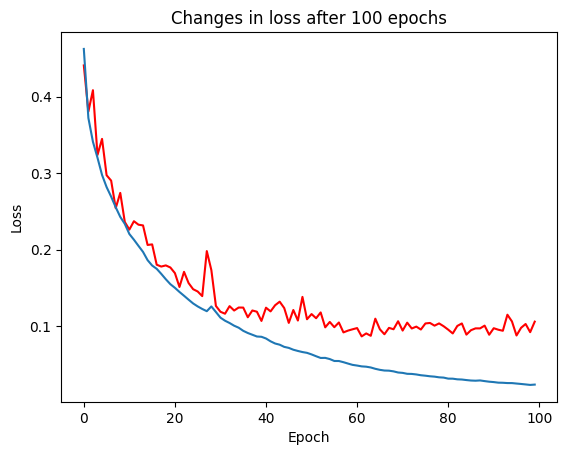

In [91]:
plt.figure()
plt.plot(np.arange(0, 100, 1), val_losses, c = "red")
plt.plot(np.arange(0, 100, 1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Changes in loss after 100 epochs")

In [82]:
torch.save(model.state_dict(), "/kaggle/working/model.pt")

In [15]:
from pathlib import Path
from sklearn.metrics import mean_absolute_error
model = Model()
checkpoint = torch.load(Path('/kaggle/input/hc-dataset/model.pt'))
model.load_state_dict(checkpoint)
model.eval()

Model(
  (conv3x3_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv3x3_2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (conv3x3_3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [84]:

mae_sum = 0
leng = len(train_cd)
for i in range(leng):
    a, b = train_cd[i]
    m = model(a.unsqueeze(0))
    mae = mean_absolute_error(m.detach().cpu().squeeze(), b.detach().cpu().squeeze())
    mae_sum += mae
# t[t>=0.8] = 1
# t[t < 0.8] = 0
avg_mae = mae_sum/leng
print(avg_mae)
# plt.imshow(t.detach().cpu().squeeze(), cmap= "gray")

ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].

In [16]:
directory_path_test = "/kaggle/input/hc-dataset/test_set/test_set"
X_test = []
test_list = os.listdir(directory_path_test)
for filename in test_list:
    filepath = os.path.join(directory_path_test, filename)
    file_content = np.array(Image.open(filepath, 'r'))
    if file_content.shape == (540,800):
        X_test.append(file_content)

In [49]:
# test_1 = X_test[210]
test_1 = valid_cd[197][0].squeeze(0)

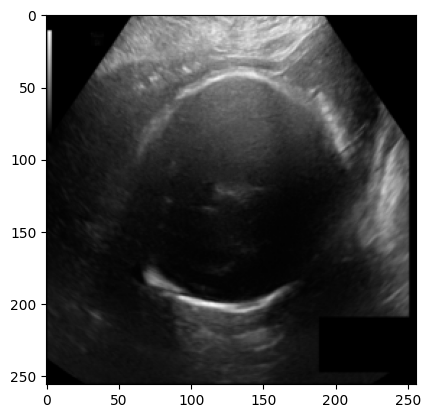

In [50]:
plt.imshow(test_1, cmap = 'gray')

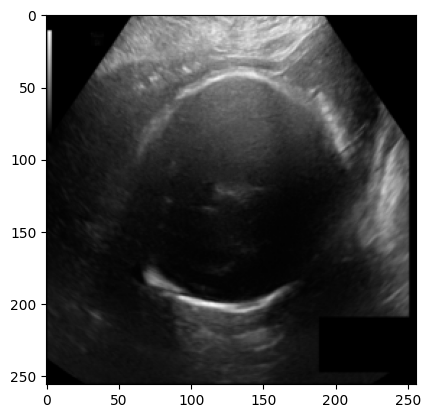

In [51]:
plt.imshow(transform_X(test_1)[0], cmap = 'gray')

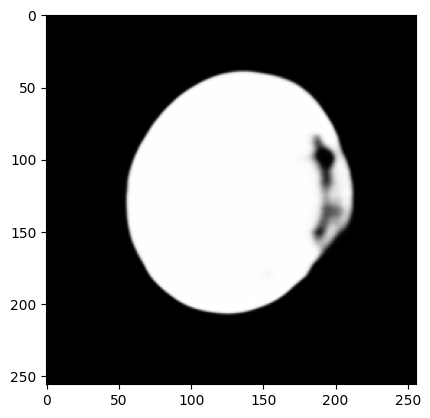

In [52]:
pred_1 = model(transform_X(test_1).unsqueeze(0))
plt.imshow(pred_1.detach().cpu().squeeze(), cmap= "gray")

In [53]:
pred_1.detach().numpy()[0][0]

array([[0.01566183, 0.01378916, 0.01300229, ..., 0.01311536, 0.01381064,
        0.01583293],
       [0.01413087, 0.01380818, 0.01305799, ..., 0.01306987, 0.01384941,
        0.01383864],
       [0.01318967, 0.01316646, 0.01299965, ..., 0.01300511, 0.013446  ,
        0.0133527 ],
       ...,
       [0.01284719, 0.01274689, 0.01257694, ..., 0.01253134, 0.01271646,
        0.01294534],
       [0.01361577, 0.01348226, 0.01288518, ..., 0.01280864, 0.01315003,
        0.01351619],
       [0.01503249, 0.01343652, 0.01273858, ..., 0.01285454, 0.0131189 ,
        0.01479198]], dtype=float32)

In [54]:
def ovalFill(data, threshold):
    imgray = data.copy()
    print(imgray.shape)
    ret, thresh = cv.threshold(imgray, 0.2, 1, 0)
    print(thresh.shape)
    contours, hierarchy = cv.findContours(thresh.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    print(len(contours[0]))
    (x, y), (major_axis, minor_axis), angle = cv.fitEllipse(contours[0])
    cv.ellipse(imgray, (int(x), int(y)), (int(major_axis // 2), int(minor_axis // 2)),
            angle, 0, 360, (255, 0, 0), 2)
    return imgray
    

(256, 256)
(256, 256)
222


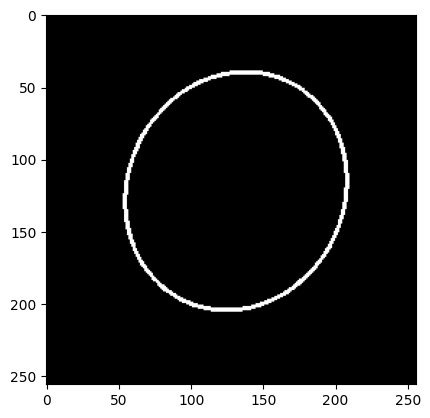

In [55]:
segmented_resize_image = ovalFill(pred_1.detach().numpy()[0][0], 0.2)
plt.imshow(segmented_resize_image, cmap = 'gray')

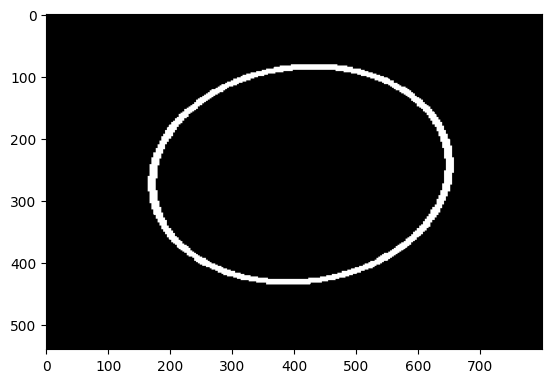

In [56]:
segmented_realsize_image = cv.resize(segmented_resize_image, (800, 540), 
               interpolation = cv.INTER_LINEAR)
segmented_realsize_image[segmented_realsize_image > 0.99] = 1
segmented_realsize_image[segmented_realsize_image <= 0.99] = 0
plt.imshow(segmented_realsize_image, cmap = 'gray')

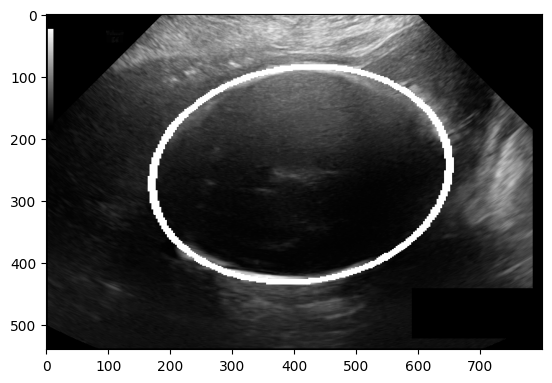

In [57]:
segmented_real_image = X_valid[197].copy()
segmented_real_image[np.where(segmented_realsize_image== 1)] = 255
plt.imshow(segmented_real_image, cmap = 'gray')

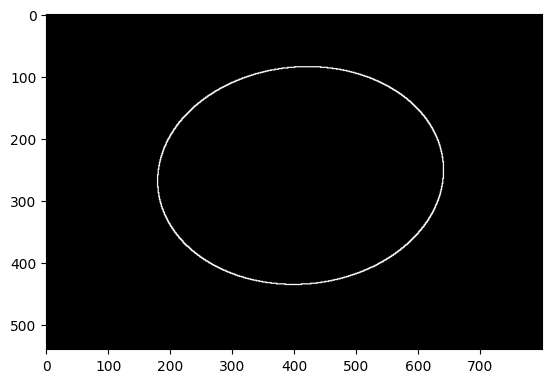

In [58]:
plt.imshow(y_valid_original[197], cmap = 'gray')

In [ ]:
test_1 = X_test[200]